23:59:38 [INFO] 🚀 Starting Unified Log Parser & Analyzer...
23:59:38 [INFO] 📁 Processing: githubactions_failure_job-logs.txt
23:59:38 [INFO]    ➤ Detected log type: deployment
23:59:38 [INFO] ✅ Loaded 1,327 lines from 1 files.
23:59:38 [INFO] 🧩 Detected log types: {'deployment'}
23:59:38 [INFO] Logs parsed successfully!
23:59:38 [INFO] 
📊 Processing subset: deployment (1,327 lines)


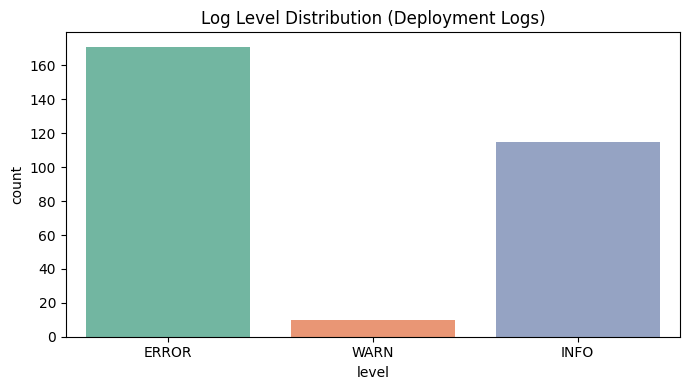

/var/folders/wd/2sz49y756sg0bpsv76m2g61c0000gn/T/ipykernel_43181/4289515329.py:223: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


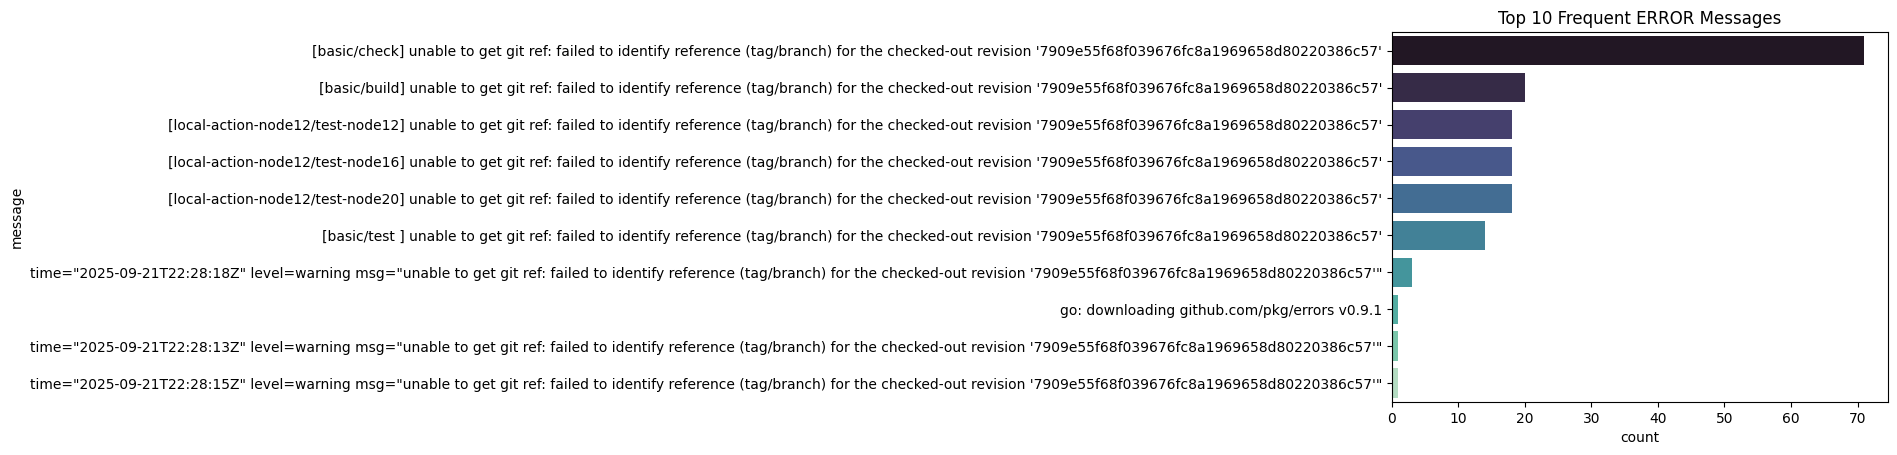

TypeError: Object of type int64 is not JSON serializable

In [ ]:
# ======================================================
# 🧠 Unified Log Parser + Token Analyzer for Thesis
# Auto-detects Application vs Deployment logs
# Author: Nikhil Chavan
# ======================================================

import os
import re
import json
import logging
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tiktoken import get_encoding

# --------------------------
# CONFIGURATION
# --------------------------
warnings.filterwarnings("ignore", category=FutureWarning)

LOG_FOLDER = "../logs"
OUTPUT_CSV = "cleaned_logs_combined.csv"
OUTPUT_JSON = "combined_log_summary.json"
ENCODING = get_encoding("cl100k_base")
MAX_LINES = 2_000_000

# --------------------------
# LOGGING SETUP
# --------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logging.info("🚀 Starting Unified Log Parser & Analyzer...")

# --------------------------
# DETECTION & PARSERS
# --------------------------

def detect_log_type(sample_line):
    """Heuristic to detect log type (Application vs Deployment)"""
    # Web / HTTP request pattern
    if re.search(r'\b(GET|POST|PUT|DELETE)\b', sample_line) and '"' in sample_line:
        return "application"

    # Jenkins / generic deployment with [INFO] style
    if re.search(r'\[(INFO|ERROR|WARN)\]', sample_line):
        return "deployment"

    # GitHub Actions / CI log ISO timestamp format (2025-09-21T22:28:14Z)
    if re.search(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}', sample_line):
        return "deployment"

    return "unknown"


def parse_application_log(line):
    """Apache/Nginx style"""
    pattern = re.compile(
        r'(?P<ip>\S+) - - \[(?P<timestamp>[^\]]+)\] '
        r'"(?P<method>[A-Z]+) (?P<path>\S+) (?P<protocol>[^"]+)" '
        r'(?P<status>\d{3}) (?P<size>\d+) '
        r'"(?P<referrer>[^"]*)" "(?P<agent>[^"]*)" ?(?P<response_time>\d+)?'
    )
    match = pattern.match(line)
    if match:
        d = match.groupdict()
        return (
            "application",
            d.get("timestamp"),
            d.get("status"),
            f"{d.get('method')} {d.get('path')}",
            d.get("response_time") or "N/A"
        )
    return None

def parse_deployment_log(line):
    """Generic parser for Jenkins / GitHub Actions / CI logs."""
    pattern = re.compile(
        r"(?P<timestamp>\d{4}-\d{2}-\d{2}[T ]\d{2}:\d{2}:\d{2}(?:\.\d+)?Z?)\s.*?(?P<msg>.*)"
    )
    match = pattern.match(line)
    if not match:
        return None

    msg = match.group("msg")

    # Infer log level heuristically
    msg_lower = msg.lower()
    if any(k in msg_lower for k in ["error", "failed", "unable", "exception", "denied"]):
        level = "ERROR"
    elif any(k in msg_lower for k in ["warn", "deprecated", "caution"]):
        level = "WARN"
    elif any(k in msg_lower for k in ["success", "complete", "done", "✅", "finished"]):
        level = "INFO"
    else:
        level = "INFO"

    return ("deployment", match.group("timestamp"), level, msg.strip(), None)

def convert_np(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Series):
        return obj.to_list()
    return obj




# --------------------------
# MAIN LOAD LOOP
# --------------------------
all_logs = []
file_count = 0
log_types = set()

for filename in os.listdir(LOG_FOLDER):
    if not (filename.endswith(".log") or filename.endswith(".txt")):
        continue
    file_count += 1
    filepath = os.path.join(LOG_FOLDER, filename)
    logging.info(f"📁 Processing: {filename}")

    detected_type = "unknown"
    with open(filepath, "r", errors="ignore") as f:
        for i, line in enumerate(f):
            if i == 0:
                detected_type = detect_log_type(line)
                log_types.add(detected_type)
                logging.info(f"   ➤ Detected log type: {detected_type}")
            if i > MAX_LINES:
                logging.warning(f"⚠️ Reached {MAX_LINES} lines limit in {filename}")
                break

            if detected_type == "application":
                parsed = parse_application_log(line)
            elif detected_type == "deployment":
                parsed = parse_deployment_log(line)
            else:
                parsed = None

            if parsed:
                all_logs.append(parsed)

if not all_logs:
    logging.error("❌ No valid logs parsed. Check folder and formats.")
else:
    logging.info(f"✅ Loaded {len(all_logs):,} lines from {file_count} files.")
    logging.info(f"🧩 Detected log types: {log_types}")

# --------------------------
# BUILD DATAFRAME
# --------------------------
df = pd.DataFrame(all_logs, columns=["log_type", "timestamp", "col3", "col4", "col5"])

if df.empty:
    logging.warning("⚠️ Empty dataframe, stopping.")
else:
    logging.info("Logs parsed successfully!")

# --------------------------
# PROCESS PER LOG TYPE
# --------------------------
summary_results = {}

for log_type in df["log_type"].unique():
    subset = df[df["log_type"] == log_type]
    logging.info(f"\n📊 Processing subset: {log_type} ({len(subset):,} lines)")

    if log_type == "application":
        subset.columns = ["log_type", "timestamp", "status", "request", "response_time"]
        subset["status"] = pd.to_numeric(subset["status"], errors="coerce")
        filtered = subset[subset["status"] >= 400]

        if filtered.empty:
            logging.warning("No HTTP errors detected (status >= 400).")
            continue

        def est_tokens(txt): return len(ENCODING.encode(str(txt)))
        filtered["token_count"] = filtered["request"].apply(est_tokens)
        avg_t = filtered["token_count"].mean()
        total_t = filtered["token_count"].sum()
        est_cost = round((total_t / 1000) * 0.01, 3)

        plt.figure(figsize=(8, 4))
        sns.countplot(data=filtered, x="status", palette="coolwarm")
        plt.title("HTTP Error Code Distribution (Application Logs)")
        plt.show()

        top_req = filtered["request"].value_counts().head(10).reset_index()
        top_req.columns = ["request", "count"]
        sns.barplot(data=top_req, x="count", y="request", palette="mako")
        plt.title("Top 10 Failing Endpoints")
        plt.tight_layout()
        plt.show()

        summary_results["application"] = {
            "total": len(subset),
            "errors": len(filtered),
            "avg_tokens": avg_t,
            "total_tokens": total_t,
            "cost_usd": est_cost,
            "status_counts": filtered["status"].value_counts().to_dict(),
        }

    elif log_type == "deployment":
        subset.columns = ["log_type", "timestamp", "level", "message", "_"]
        filtered = pd.concat([
            subset[subset["level"].isin(["ERROR", "WARN"])],
            subset[subset["level"] == "INFO"].sample(frac=0.1, random_state=42)
        ])

        def est_tokens(txt): return len(ENCODING.encode(str(txt)))
        filtered["token_count"] = filtered["message"].apply(est_tokens)
        avg_t = filtered["token_count"].mean()
        total_t = filtered["token_count"].sum()
        est_cost = round((total_t / 1000) * 0.01, 3)

        plt.figure(figsize=(7, 4))
        sns.countplot(data=filtered, x="level", order=["ERROR", "WARN", "INFO"], palette="Set2")
        plt.title("Log Level Distribution (Deployment Logs)")
        plt.tight_layout()
        plt.show()

        top_err = filtered[filtered["level"] == "ERROR"]["message"].value_counts().head(10).reset_index()
        top_err.columns = ["message", "count"]
        sns.barplot(data=top_err, x="count", y="message", palette="mako")
        plt.title("Top 10 Frequent ERROR Messages")
        plt.tight_layout()
        plt.show()

        summary_results["deployment"] = {
            "total": len(subset),
            "filtered": len(filtered),
            "avg_tokens": avg_t,
            "total_tokens": total_t,
            "cost_usd": est_cost,
            "level_counts": filtered["level"].value_counts().to_dict(),
        }

# --------------------------
# EXPORT RESULTS
# --------------------------
# Clean dict before saving
clean_summary = json.loads(json.dumps(summary_results, default=convert_np))
if summary_results:
    df.to_csv(OUTPUT_CSV, index=False)
    with open(OUTPUT_JSON, "w") as f:
        json.dump(clean_summary, f, indent=4)

    logging.info("✅ Exported combined results:")
    logging.info(f"   - {OUTPUT_CSV}")
    logging.info(f"   - {OUTPUT_JSON}")
    logging.info("📈 Unified log analysis complete.")
